In [1]:
# General purpose
import numpy as np
import pandas as pd
from glob import glob

# Metrics
from cellpose_omni.metrics import average_precision

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io
from MEDUSSA.utils import BorderRemoval

In [6]:
basedir = '/Volumes/evocell/Octavio/Omnipose/Benchmarking/'

manual_masks = sorted(glob(f'{basedir}Test_masks/*.tif'))

fmseg_masks_deconvolved = sorted(glob(f'{basedir}omnipose_deconvolved_masks/masks_GUI/0*'))

bfo_masks_deconvolved = sorted(glob(f'{basedir}BFO_masks_deconvolved/0*'))

cyto3_masks_deconvolved = sorted(glob(f'{basedir}Cyto3_masks_deconvolved/0*'))

print(len(manual_masks))
assert len(manual_masks) == len(fmseg_masks_deconvolved), "different amount of deconvolved FM masks segmented with membSeg than manually annotated masks"
assert len(manual_masks) == len(bfo_masks_deconvolved), "different amount of deconvolved FM masks segmented with bact_fluor_omni than manually annotated masks"
assert len(manual_masks) == len(cyto3_masks_deconvolved), "different amount of deconvolved FM masks segmented with cyto3 than manually annotated masks"

manual_masks = [io.imread(mask) for mask in manual_masks]

fmseg_masks_deconvolved = [BorderRemoval(io.imread(mask)) for mask in fmseg_masks_deconvolved]

bfo_masks_deconvolved = [BorderRemoval(io.imread(mask)) for mask in bfo_masks_deconvolved]

cyto3_masks_deconvolved = [BorderRemoval(io.imread(mask)) for mask in cyto3_masks_deconvolved]


16


In [7]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

JI_deconvolved, tp, fp, fn = average_precision(manual_masks,fmseg_masks_deconvolved,threshold=thresholds)
f1_deconvolved = 2*tp/(2*tp+fn+fp)

JI_bwo_d, tp, fp, fn = average_precision(manual_masks,bfo_masks_deconvolved,threshold=thresholds)
f1_bwo_d = 2*tp/(2*tp+fn+fp)

JI_cyto3_d, tp, fp, fn = average_precision(manual_masks,cyto3_masks_deconvolved,threshold=thresholds)
f1_cyto3_d = 2*tp/(2*tp+fn+fp)


In [8]:
dfs = []

for i in range(len(manual_masks)):

    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    df3 = pd.DataFrame()
    df4 = pd.DataFrame()
    
    df1.insert(0,'F1',f1_deconvolved[i])
    df1.insert(0,'Threshold',thresholds)
    df1.insert(0,'Model','Our model')

    df2.insert(0,'F1',f1_bwo_d[i])
    df2.insert(0,'Threshold',thresholds)
    df2.insert(0,'Model','bact_fluor_omni')

    df3.insert(0,'F1',f1_cyto3_d[i])
    df3.insert(0,'Threshold',thresholds)
    df3.insert(0,'Model','Cyto3')

    df = pd.concat([df1,df2,df3,df4],ignore_index=True)
    dfs.append(df)

dfs = pd.concat(dfs,ignore_index=True)
dfs.to_csv(f'{basedir}Deconvolved_images_metrics.csv')


/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_56690/2098717120.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(labels=ax[0].get_yticklabels(),fontsize=12)
/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_56690/2098717120.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=ax[0].get_xticklabels(),fontsize=12)
/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_56690/2098717120.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),fontsize=12)


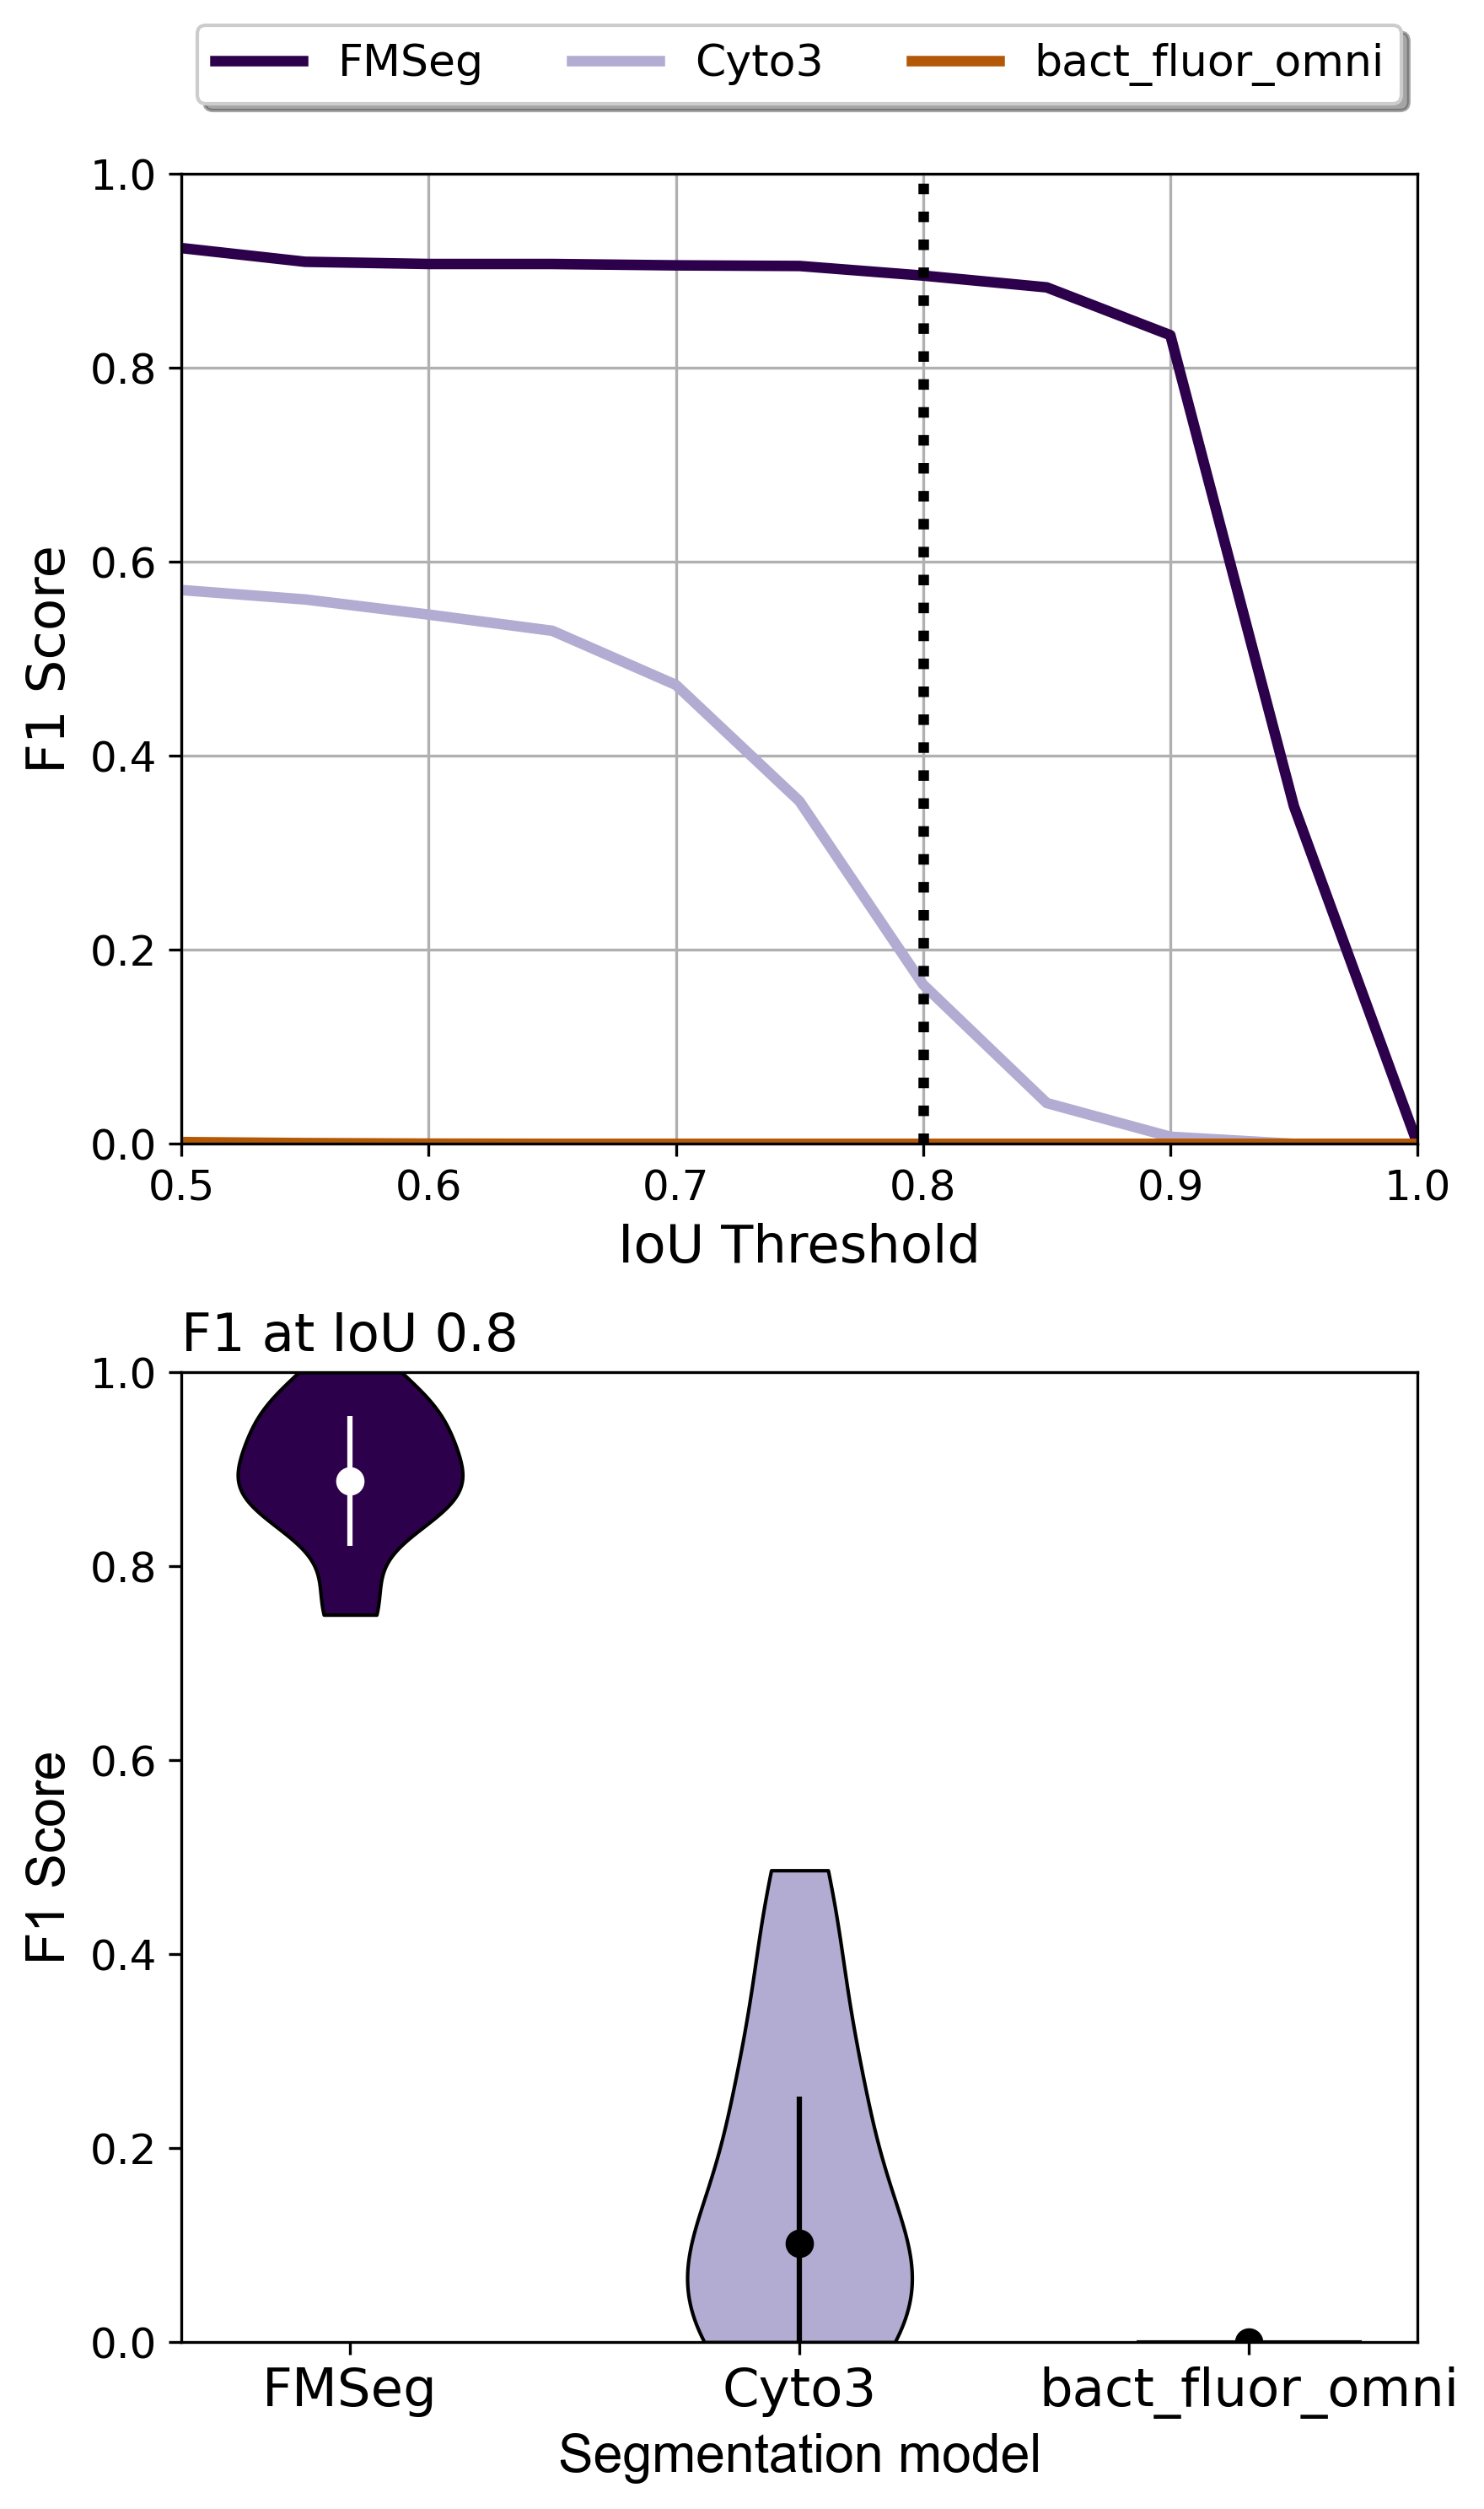

In [9]:
dfs = pd.read_csv(f'{basedir}Deconvolved_images_metrics.csv')
dfs = dfs.drop("Unnamed: 0",axis=1)

fig,ax = plt.subplots(dpi=300, nrows=2, ncols=1, figsize=(6,10))

ax[0].grid(visible=True,axis='both')
ax[0].set_ylabel('F1 Score',fontsize=15)
ax[0].set_ylim(0,1)
ax[0].set_yticklabels(labels=ax[0].get_yticklabels(),fontsize=12)

ax[0].set_xlabel('IoU Threshold',fontsize=15)
ax[0].set_xlim(0.5,1)
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(),fontsize=12)

models = ['Our model','Cyto3','bact_fluor_omni']
colors = ['#2d004b','#b2abd2','#b35806']

fscores = []

for i,model in enumerate(models):
    
    subdf = dfs[dfs['Model'] == model]

    fscores.append(np.array(subdf[subdf['Threshold'] == 0.8]['F1']))
    
    newdf = subdf.drop('Model',axis=1).groupby('Threshold').mean()
    ax[0].plot(newdf,label=model, c=colors[i], linewidth=3)
    
ax[0].legend(loc='lower center', labels = ['FMSeg','Cyto3','bact_fluor_omni'], bbox_to_anchor=(0.5, 1.05),fancybox=True, shadow=True, ncol=3,fontsize=12.5)
ax[0].axvline(0.8,c='k',linestyle=':',linewidth=3)
#ax[0].axhline(0.9,c='k',linestyle=':',linewidth=3)

positions = [0,1,2]

parts1 = ax[1].violinplot(fscores,positions,showmeans=False,showmedians=False,showextrema=False)

for i,pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

colors2 = ['w','k','k']

for f,p in zip(fscores,positions):
    ax[1].errorbar(x=p,y=np.median(f),yerr=np.std(f),color=colors2[p])
    ax[1].scatter(x=p,y=np.median(f),color=colors2[p],s=50)
    
ax[1].set_xticks([0,1,2])
ax[1].set_ylim(0,1)
ax[1].set_xticklabels(['FMSeg','Cyto3','bact_fluor_omni'],fontsize=15)
ax[1].set_xlabel('Segmentation model', fontsize=15,fontname='Arial')
ax[1].set_ylabel('F1 Score',fontname='Arial',fontsize=15)
ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),fontsize=12)
ax[1].set_title('F1 at IoU 0.8', fontsize=15, loc='left')

fig.tight_layout()
fig.savefig(f'{basedir}F1_scores_deconvolved.png')